## Содержание
* [Импорт данных и анализ](#0)
    * [Импорт](#.1)
    * [Анализ](#.2)
* [Экстракция и создание признаков](#1)
* [Обучение моделей](#2)
    * [Задача обучения](#2.0)
    * [Recall](#2.1)
    * [ROC-AUC](#2.2)
    * [Результаты обучения](#2.3)
* [Общий вывод](#3)

## Описание кейса

Неназванная маркетинговая компания передала нам данные о поведении пользователей в трёх источниках - магазине одежды, магазине подарков и маркетплейсе. На их основе она просит создать модель, которая сможет предсказывать, совершит ли клиент покупку в течение 30 дней после текущей.

## Импорт данных и анализ  <a class="anchor"  id="0"></a>

### Импорт <a class="anchor"  id=".1"></a>

Устанавливаем библиотеку shap для анализа важности параметров моделей

In [1]:
!pip install shap

Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score ,precision_score, \
roc_auc_score, roc_curve, confusion_matrix
import shap

Сразу укажем параметр random_state, который будем использовать, чтобы обеспечить репродуцируемость работы

In [3]:
RANDOM_STATE = 113

Загружаем .csv файлы в переменные

In [4]:
apparel_data = pd.read_csv('/kaggle/input/customer-data-secret/apparel-purchases.csv',
                           parse_dates=['date'])
gifts_data = pd.read_csv('/kaggle/input/customer-data-secret/gifts-purchases.csv',
                         parse_dates=['date'])
marketplace_data = pd.read_csv('/kaggle/input/customer-data-secret/marketplace-purchases.csv',
                               parse_dates=['date', 'created_at'])

Посмотрим на то, какие данные у нас в распоряжении

### Анализ <a class="anchor"  id=".2"></a>

In [5]:
apparel_data.info()
apparel_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [6]:
gifts_data.info()
gifts_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       811 non-null    int64         
 1   quantity        811 non-null    int64         
 2   price           811 non-null    float64       
 3   date            811 non-null    datetime64[ns]
 4   message_id      811 non-null    object        
 5   recommended_by  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 38.1+ KB


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


Всего 811 записей в данных из магазина подарков, и, как мы можем видеть по одинаковым <b>client_id</b> и <b>date</b> первых пяти записей - вероятнее всего это один заказ. Если переводить записи в заказы (что нам впоследствии придётся сделать), количество записей для обучения будет ещё меньше. Уже можно сказать, что вероятнее всего строить модель для обучения отдельно на магазине подарков мы не будем

In [7]:
marketplace_data.info()
marketplace_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.2+ MB


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


Поля <b>recommended_by</b> в данных с маркетплейса нет, а так же есть два столбца с датой - <b>date</b> и <b>created_at</b>. Возможно, некоторые клиенты и правда совершали следующий заказ через несколько часов или минут после первого, но такие ситуации будет черезвычайно сложно предсказать, да и задача бизнеса звучит немного не так. Объединим и эти данные в заказы по дате, без времени

Значения в поле <b>message_id</b> до первого дефиса подозрительно напоминают значения поля <b>client_id</b>. Проверим, везде ли они совпадают - если да, то, возможно, всё, что идёт после дефиса, мы сможем как-то классифицировать и использовать в обучении модели или моделей

In [8]:
apparel_data['message_id'].str.split('-', n=1, expand=True)[0].astype('int') == \
apparel_data['client_id']

0          True
1          True
2          True
3          True
4          True
          ...  
133099    False
133100    False
133101    False
133102    False
133103    False
Length: 133104, dtype: bool

Наша гипотеза не подтвердилась - как минимум в данных с магазина одежды они совпадают не везде. Проверим теперь значения поля <b>recommended_by</b>

In [9]:
print(apparel_data['recommended_by'].unique())
gifts_data['recommended_by'].unique()

['bulk_message']


array(['bulk_message'], dtype=object)

Только одно значение. Для обучения у нас остаётся 4 столбца - <b>client_id</b> и <b>date</b>, на основе которых мы будем объединять данные в заказы, а так же <b>price</b> и <b>quantity</b>, которые обозначают цену товара и его количество в заказе

Посмотрим, за какой период наши данные

In [10]:
print(apparel_data.sort_values(by='date')['date'])
print(gifts_data.sort_values(by='date')['date'])
marketplace_data.sort_values(by='date')['date']

42189    2022-10-26
16873    2022-10-26
16872    2022-10-26
58333    2022-10-26
58334    2022-10-26
            ...    
110360   2023-10-26
112056   2023-10-26
112055   2023-10-26
110356   2023-10-26
111342   2023-10-26
Name: date, Length: 133104, dtype: datetime64[ns]
209   2022-10-26
210   2022-10-26
211   2022-10-26
212   2022-10-26
213   2022-10-26
         ...    
28    2023-10-22
27    2023-10-22
34    2023-10-24
33    2023-10-24
35    2023-10-24
Name: date, Length: 811, dtype: datetime64[ns]


26693   2022-10-26 08:35:46
15660   2022-10-27 17:12:22
15661   2022-10-27 17:12:22
15662   2022-10-27 17:12:22
15663   2022-10-27 17:19:44
                ...        
24500   2023-10-26 11:23:08
24502   2023-10-26 12:43:55
24501   2023-10-26 12:43:55
24494   2023-10-26 13:15:32
24443   2023-10-26 13:34:11
Name: date, Length: 48182, dtype: datetime64[ns]

Все данные за год, кроме данные магазина подарков (или в нём не было покупок 25 и 26 октября, что вполне вероятно)

Подгоним данные из маркетплейса под магазинный формат и объединим всю имеющуюся информацию в таблицу <b>total_data</b>

In [11]:
marketplace_data = marketplace_data.drop('date', axis=1)
marketplace_data.rename(columns={'created_at':'date'}, inplace=True)

total_data = pd.concat([apparel_data, gifts_data, marketplace_data], ignore_index=True)
total_data.info()
total_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182097 entries, 0 to 182096
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       182097 non-null  int64         
 1   quantity        182097 non-null  int64         
 2   price           182097 non-null  float64       
 3   date            182097 non-null  datetime64[ns]
 4   message_id      182097 non-null  object        
 5   recommended_by  133915 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 8.3+ MB


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


Пропуски в recommended_by нам не страшны, это поле нам не нужно. Попробуем собрать больше информации о данных с помощью библиотеки <b>statsmodels</b>

Создаём временной ряд в переменной <b>time</b>

In [12]:
time = total_data.set_index('date').sort_index().drop(['message_id', 'recommended_by'],
                                                      axis=1)

time

,client_id,quantity,price
date,,,
2022-10-26,1515915625581772632,1,2100.0
2022-10-26,1515915625558655965,1,767.0
2022-10-26,1515915625558655965,1,1150.0
2022-10-26,1515915625500418210,1,1859.0
2022-10-26,1515915625562386426,1,10598.0
...,...,...,...
2023-10-26,1515915625999034637,1,2030.0
2023-10-26,1515915625559924944,1,1499.0
2023-10-26,1515915625559351663,1,700.0


Посмотрим на данные через призму количества купленных товаров и их цены относительно средней стоимости товара.

In [13]:
decomposed_price = seasonal_decompose(
    (time['price'] / time['price'].mean()).resample('1d').sum())

decomposed_quantity = seasonal_decompose(time['quantity'].resample('1d').sum())

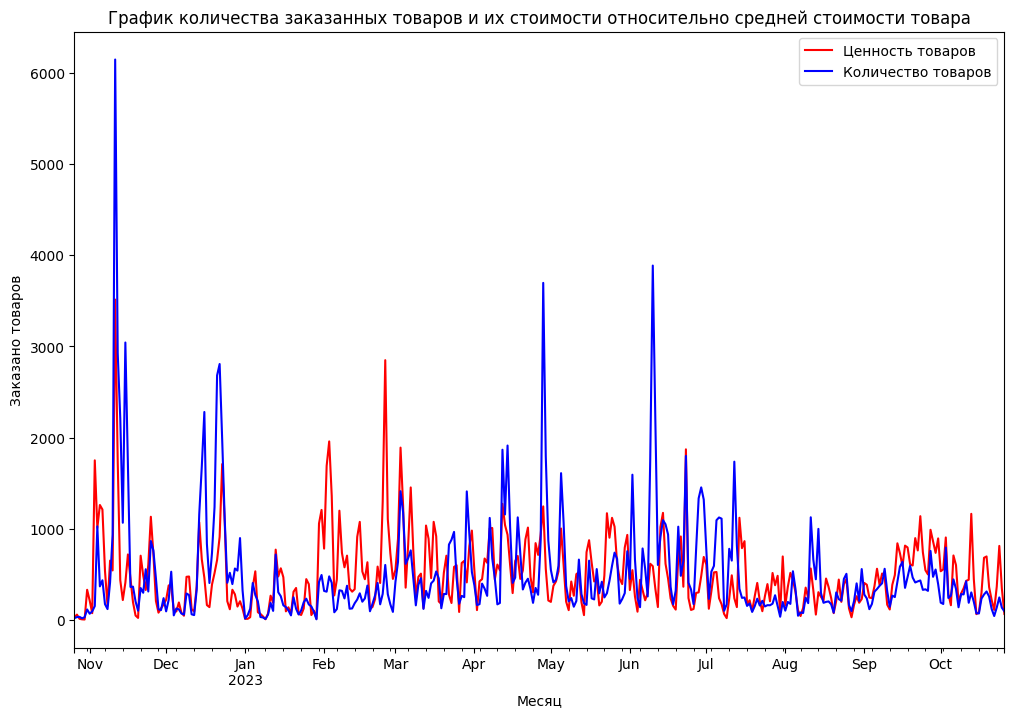

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
decomposed_price.observed.plot(label='Ценность товаров', color='r');
decomposed_quantity.observed.plot(label='Количество товаров', color='b');
plt.title('График количества заказанных товаров и их стоимости относительно \
средней стоимости товара')
plt.xlabel('Месяц')
plt.ylabel('Заказано товаров')
plt.legend()
plt.show()

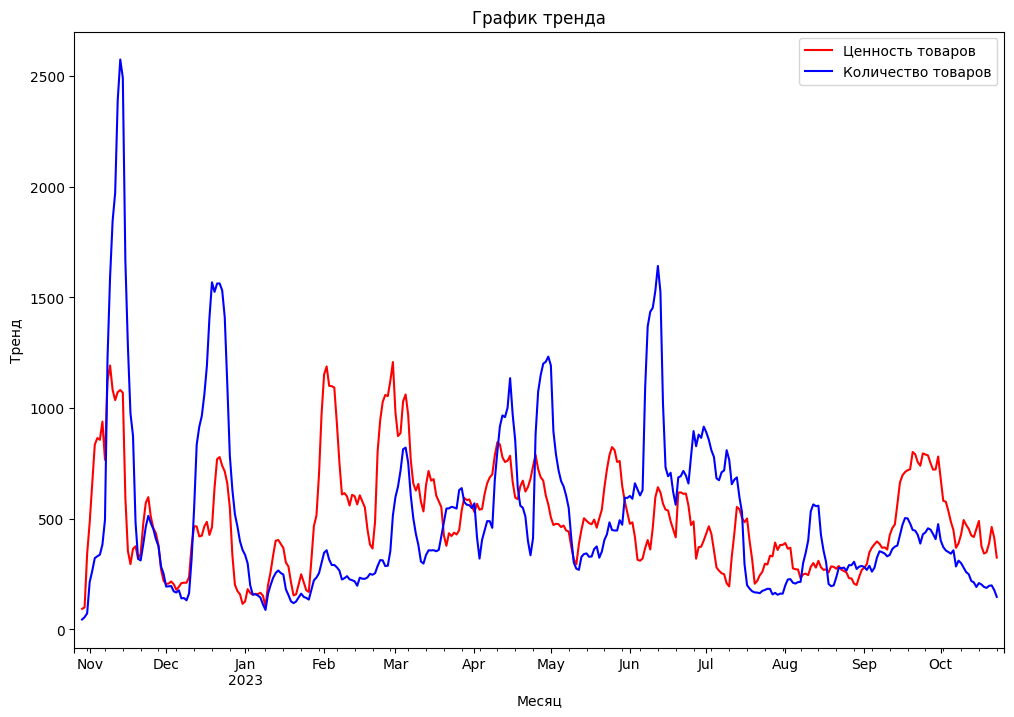

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
decomposed_price.trend.plot(label='Ценность товаров', color='r');
decomposed_quantity.trend.plot(label='Количество товаров', color='b');
plt.title('График тренда')
plt.xlabel('Месяц')
plt.ylabel('Тренд')
plt.legend()
plt.show()

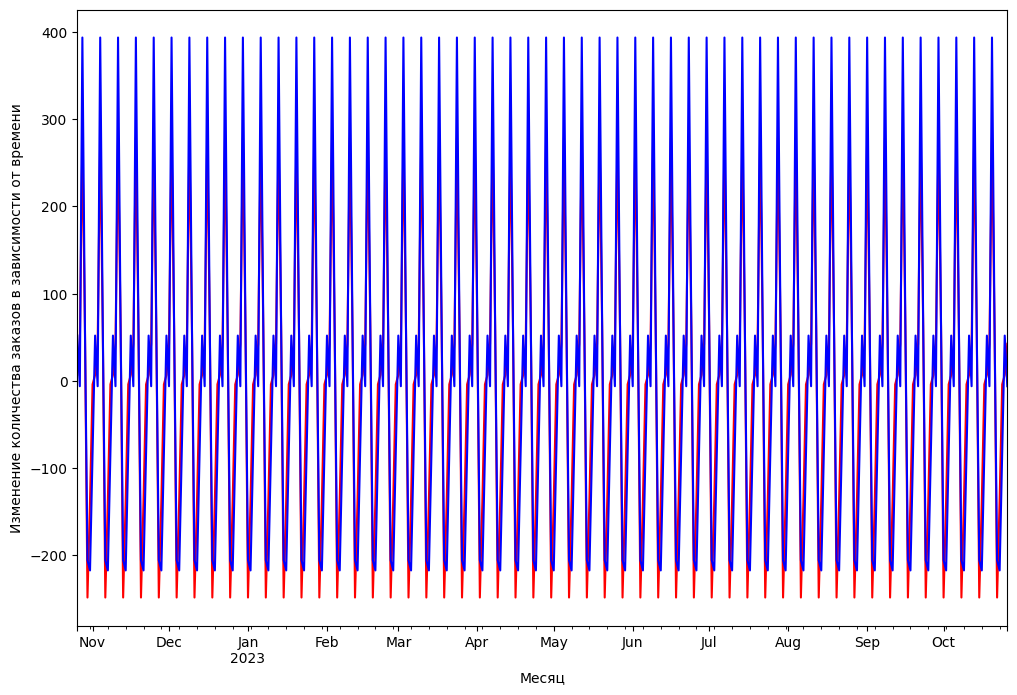

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
decomposed_price.seasonal.plot(color='r');
decomposed_quantity.seasonal.plot(color='b');
plt.xlabel('Месяц')
plt.ylabel('Изменение количества заказов в зависимости от времени')
plt.show()

Судя по количеству пиков, это недельная сезонность. Посмотрим на одну неделю

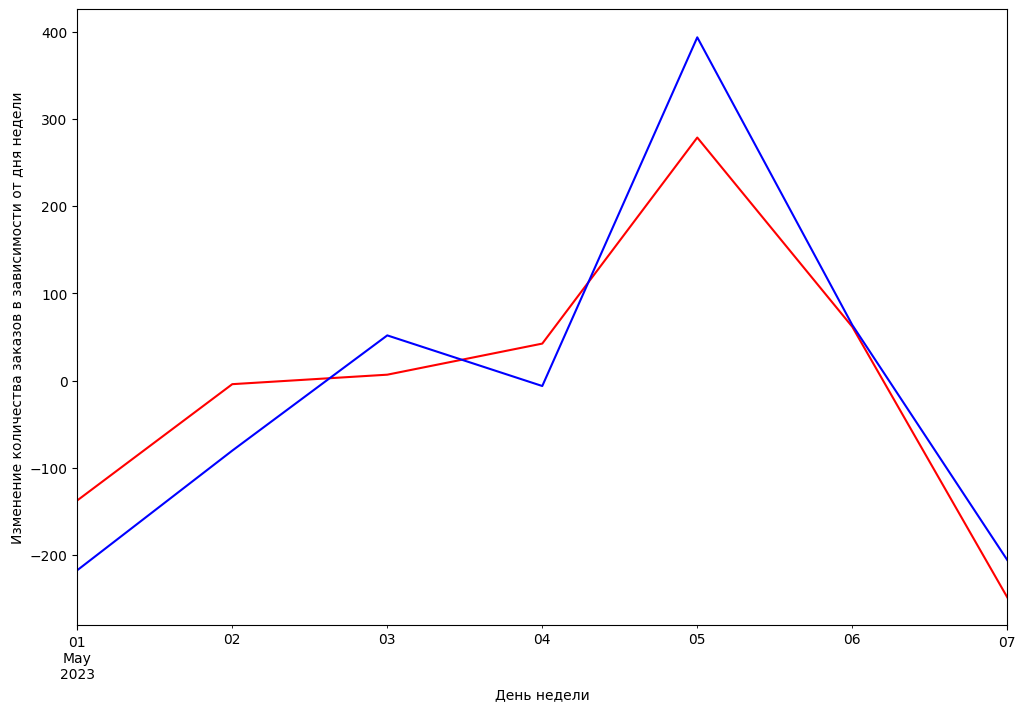

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
decomposed_price.seasonal['2023-05':'2023-05-07'].plot(color='r');
decomposed_quantity.seasonal['2023-05':'2023-05-07'].plot(color='b');
plt.xlabel('День недели')
plt.ylabel('Изменение количества заказов в зависимости от дня недели')
plt.show()

Похоже, больше всего заказов совершают в пятницу. Большую сезонность, даже если мы сможем её получить, и линию тренда сложно будет использовать, ведь у нас данные только за один год

Перейдём к созданию признаков

## Экстракция и создание признаков <a class="anchor"  id="1"></a>

Добавим к наборам данных следующие признаки:
- <b>день недели</b>, в который совершён заказ
- как давно был сделан <b>первый заказ</b>
- как давно был сделан <b>предыдущий заказ</b>
- какой это <b>по счёту заказ</b>
- <b>сколько всего клиент принёс денег</b> на момент заказа
- <b>сколько всего он купил товаров</b> на момент заказа
- <b>средняя стоимость одного купленного товара</b> на момент заказа
- <b>дата спустя 30 дней и какой это день недели</b>
- <b>дата и день через неделю, две недели и три недели</b>
- <b>RFM_Score</b> (ценность клиента для компании) на момент покупки
- и <b>целевой признак</b> - 1, если в течение 30 дней после этого заказа клиент совершил ещё один, и 0, если заказов после этого не было или они были больше месяца спустя

А так же нам придётся обрезать последние 30 дней, потому что для них нельзя адекватно создать целевой признак, но сделать это нужно будет уже после создания целевого признака

In [18]:
def feature_extraction(data):
    
    data = data.groupby(['client_id', 'date'])[['price', 'quantity']].sum().reset_index()
    
    data['target'] = (data.groupby('client_id')['date'].apply(lambda x: x.shift(-1) - x).dt.days).reset_index()['date']
    data['target'] = data['target'].fillna(999)
    data['target'] = np.where(data['target'] <= 30, 1, 0)
    
    data = data.sort_values(by='date').query('date < "2023-09-26"')
    
    data['day_of_week'] = data['date'].dt.dayofweek

    data['first_order'] = (data.groupby('client_id')['date'].apply(lambda x: x - x.min()).dt.days).reset_index()['date']
    data['first_order'] = data['first_order'].fillna(999)

    data['last_order'] = (data.groupby('client_id')['date'].apply(lambda x: x - x.shift(1)).dt.days).reset_index()['date']
    data['last_order'] = data['last_order'].fillna(999)

    data['frequency'] = 1
    data['frequency'] = (data.groupby('client_id')['frequency'].apply(lambda x: np.cumsum(x))).reset_index()['frequency']
    data['frequency'] = data['frequency'].fillna(1)

    data['mv'] = data['price']
    data['mv'] = (data.groupby('client_id')['mv'].apply(lambda x: np.cumsum(x))).reset_index()['mv']
    data['mv'] = data['mv'].fillna(data['price'])

    data['total_quantity'] = data['quantity']
    data['total_quantity'] = (data.groupby('client_id')['total_quantity'].apply(lambda x: np.cumsum(x))).reset_index()['total_quantity']
    data['total_quantity'] = data['total_quantity'].fillna(data['quantity'])
    
    data['avg_price'] = data['mv'] / data['total_quantity']

    data['month_after'] = data['date'] + pd.Timedelta(days=30)
    data['day_of_week_month_after'] = data['month_after'].dt.dayofweek

    data['week_after'] = data['date'] + pd.Timedelta(days=7)
    data['day_of_month_week_after'] = data['week_after'].dt.day

    data['two_weeks_after'] = data['date'] + pd.Timedelta(days=14)
    data['day_of_month_two_weeks_after'] = data['two_weeks_after'].dt.day

    data['three_weeks_after'] = data['date'] + pd.Timedelta(days=21)
    data['day_of_month_three_weeks_after'] = data['three_weeks_after'].dt.day
    
    data['Recency'] = data['last_order'].rank(ascending=False)
    data['Frequency'] = data['frequency'].rank(ascending=True)
    data['Monetary_Value'] = data['mv'].rank(ascending=True)
 
    data['Recency_norm'] = (data['Recency']/data['Recency'].max())*100
    data['Frequency_norm'] = (data['Frequency']/data['Frequency'].max())*100
    data['Monetary_Value_norm'] = (data['Monetary_Value']/data['Monetary_Value'].max())*100

    data['RFM_Score'] = 0.15*data['Recency_norm']+0.28 * data['Frequency_norm']+0.57*data['Monetary_Value_norm']
    data['RFM_Score'] *= 0.05
    data['RFM_Score'] = data['RFM_Score'].round(2)
 
    data.drop(columns=['Recency', 'Frequency', 'Monetary_Value', 'Recency_norm', 'Frequency_norm', 'Monetary_Value_norm'], inplace=True)
    
    return data.reset_index(drop=True)

Преобразуем все наши данные

In [19]:
apparel = feature_extraction(apparel_data)
gifts = feature_extraction(gifts_data)
marketplace = feature_extraction(marketplace_data)
total = feature_extraction(total_data)
total.head()

,client_id,date,price,quantity,target,day_of_week,first_order,last_order,frequency,mv,...,avg_price,month_after,day_of_week_month_after,week_after,day_of_month_week_after,two_weeks_after,day_of_month_two_weeks_after,three_weeks_after,day_of_month_three_weeks_after,RFM_Score
0,1515915625857065470,2022-10-26,174768.0,5,0,2,0.0,999.0,1.0,1899.0,...,1899.000000,2022-11-25,4,2022-11-02,2,2022-11-09,9,2022-11-16,16,1.55
1,1515915625468222486,2022-10-26,7998.0,2,0,2,0.0,999.0,1.0,398.0,...,132.666667,2022-11-25,4,2022-11-02,2,2022-11-09,9,2022-11-16,16,1.03
2,1515915625587818098,2022-10-26,17998.0,2,0,2,0.0,999.0,1.0,3698.0,...,1849.000000,2022-11-25,4,2022-11-02,2,2022-11-09,9,2022-11-16,16,2.09
3,1515915625562386426,2022-10-26,10598.0,1,0,2,0.0,999.0,1.0,12998.0,...,12998.000000,2022-11-25,4,2022-11-02,2,2022-11-09,9,2022-11-16,16,2.88
4,1515915625581772632,2022-10-26,2100.0,1,0,2,0.0,999.0,1.0,17394.0,...,2174.250000,2022-11-25,4,2022-11-02,2,2022-11-09,9,2022-11-16,16,2.98


Посмотрим, сколько всего объектов класса 0 и 1 получилось из данных магазина подарков

In [20]:
gifts['target'].value_counts()

target
0    326
1     20
Name: count, dtype: int64

Совсем немного, обучиться на таком наборе получится плохо

Посмотрим, какова доля класса 1 в общем наборе данных

In [21]:
print('Класс 1 занимает {:.2%} процентов'.format(total['target'].value_counts()[1] / len(total)))

Класс 1 занимает 10.41% процентов


Создадим список всех переменных, которые являются категориальными

In [22]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54121 entries, 0 to 54120
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   client_id                       54121 non-null  int64         
 1   date                            54121 non-null  datetime64[ns]
 2   price                           54121 non-null  float64       
 3   quantity                        54121 non-null  int64         
 4   target                          54121 non-null  int64         
 5   day_of_week                     54121 non-null  int32         
 6   first_order                     54121 non-null  float64       
 7   last_order                      54121 non-null  float64       
 8   frequency                       54121 non-null  float64       
 9   mv                              54121 non-null  float64       
 10  total_quantity                  54121 non-null  float64       
 11  av

In [23]:
CAT_FEATURES=['day_of_week', 'day_of_week_month_after', 'day_of_month_week_after', 'day_of_month_two_weeks_after', 'day_of_month_three_weeks_after']

Разделим данные магазина одежды, маркетплейса и общие данные на трейн и тест, магазин подарков имеет очень мало значений, и на нём мы проверять модель не будем

In [24]:
total_X_train, total_X_test, total_y_train, total_y_test = \
train_test_split(total.drop(['target', 'client_id'], axis=1),
                 total['target'], test_size=0.1, random_state=RANDOM_STATE)

apparel_X_train, apparel_X_test, apparel_y_train, apparel_y_test = \
train_test_split(apparel.drop(['target', 'client_id'], axis=1), apparel['target'],
                 test_size=0.1, random_state=RANDOM_STATE)

marketplace_X_train, marketplace_X_test, marketplace_y_train, marketplace_y_test = \
train_test_split(marketplace.drop(['target', 'client_id'], axis=1), marketplace['target'],
                 test_size=0.1, random_state=RANDOM_STATE)

Признаки созданы, данные разделены на выборки, можем приступать к обучению моделей

## Обучение моделей <a class="anchor"  id="2"></a>

Создадим функции для оценки значимости фич и оценки результатов

In [25]:
def feature_importance(model, X_test):
    shap_test = shap.TreeExplainer(model).shap_values(X_test)
    shap.summary_plot(shap_test, X_test, max_display=25, plot_size=(6, 6))
    importance = pd.DataFrame(model.get_feature_importance(),
                              index=X_test.columns,columns=['Влияение на целевой признак'])
    print(importance.sort_values(by='Влияение на целевой признак', ascending=False))
    return importance.sort_values(by='Влияение на целевой признак', ascending=False)

In [26]:
def results(model, X_test, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

    plt.figure()

    plt.plot(fpr, tpr)
    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая на тестовом наборе данных')

    plt.show()

    matrix = confusion_matrix(y_test, model.predict(X_test))
    ax = sns.heatmap(matrix, annot=True, fmt='.0f')
    ax.set_xticklabels(['True', 'False'])
    ax.set_yticklabels(['True', 'False']);
    plt.show()

    print('Правильно определённые клиенты -', matrix[0][0] + matrix[1][1],
          'неправильно определённые клиенты -', matrix[0][1] + matrix[1][0])
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    print('ROC-AUC на тестовой выборке', roc_auc)
    print('F1 на тестовой выборке',
          f1_score(y_test, model.predict(X_test)))
    print('Recall на тестовой выборке', recall)
    print('Precision на тестовой выборке', precision)
    
    return [roc_auc, recall, precision]

Определяем список параметров, котоыре наши модели будут перебирать в поисках лучшего сочетания

In [27]:
parameters = {'depth': [4, 5, 6],
              'learning_rate': [0.0023, 0.0025, 0.003]
             }

### Задача обучения <a class="anchor"  id="2.0"></a>

Постоянные клиенты очень важны для любого бизнеса, над тем, чтобы сделать клиента постоянным и удержать трудится огромное количество человек разных профессий

За то, какое количество клиентов, которые совершат покупку в течении 30 дней, модель смогла определить отвечает метрика Recall (полнота, какой процент от всех клиентов с целевым показателем 1 модель смогла вычислить)

Но чтобы модель была не только ориентирована на определение будущих постоянных клиентов, но и была в этом эффективна (например, не определяла всех клиентов как постоянных, чтобы получить хороший результат), будем ориентироваться так же на метрику ROC-AUC (её смысл в том, насколько хорошо модель разделяет клиентов)

Создадим две модели CatBoostClassifier, поставим целевые метрики Recall и ROC-AUC

Модель с метрикой Recall будет пытаться определить как можно больше покупок с целевым признаком, а модель с метрикой AUC будет пытаться соблюсти баланс и не наделать ошибок. Посмотрим, насколько разным получится их результат

Настройка моделей будет заключаться в определении лучшего сочетания глубины решаюего дерева и скорости обучения

### Recall <a class="anchor"  id="2.1"></a>

In [28]:
recall_cat = CatBoostClassifier(eval_metric='Recall:hints=skip_train~false',
                                iterations=4001, cat_features=CAT_FEATURES,
                                auto_class_weights='Balanced', random_state=RANDOM_STATE,
                                verbose=1000, metric_period=1000)

In [29]:
recall_cat_grid = recall_cat.grid_search(parameters, total_X_train, total_y_train,
                                         cv=4, partition_random_seed=RANDOM_STATE)

print('Лучшие параметры -', recall_cat.get_params(), ', лучший результат -',
      recall_cat_grid['cv_results']['test-Recall-mean'][-1])

0:	learn: 0.5630586	test: 0.5833333	best: 0.5833333 (0)	total: 107ms	remaining: 7m 9s
1000:	learn: 0.5548659	test: 0.5607843	best: 0.5833333 (0)	total: 36.7s	remaining: 1m 49s
2000:	learn: 0.5729891	test: 0.5794118	best: 0.5833333 (0)	total: 1m 12s	remaining: 1m 12s
3000:	learn: 0.5858987	test: 0.5843137	best: 0.5843137 (3000)	total: 1m 50s	remaining: 37s
4000:	learn: 0.5921053	test: 0.5843137	best: 0.5843137 (3000)	total: 2m 29s	remaining: 0us

bestTest = 0.5843137255
bestIteration = 3000

0:	loss: 0.5843137	best: 0.5843137 (0)	total: 2m 29s	remaining: 19m 55s
0:	learn: 0.5630586	test: 0.5833333	best: 0.5833333 (0)	total: 48.5ms	remaining: 3m 13s
1000:	learn: 0.5588381	test: 0.5686275	best: 0.5833333 (0)	total: 39.8s	remaining: 1m 59s
2000:	learn: 0.5774578	test: 0.5823529	best: 0.5833333 (0)	total: 1m 17s	remaining: 1m 17s
3000:	learn: 0.5873883	test: 0.5833333	best: 0.5833333 (0)	total: 1m 55s	remaining: 38.5s
4000:	learn: 0.5940914	test: 0.5852941	best: 0.5852941 (4000)	total: 2m 3

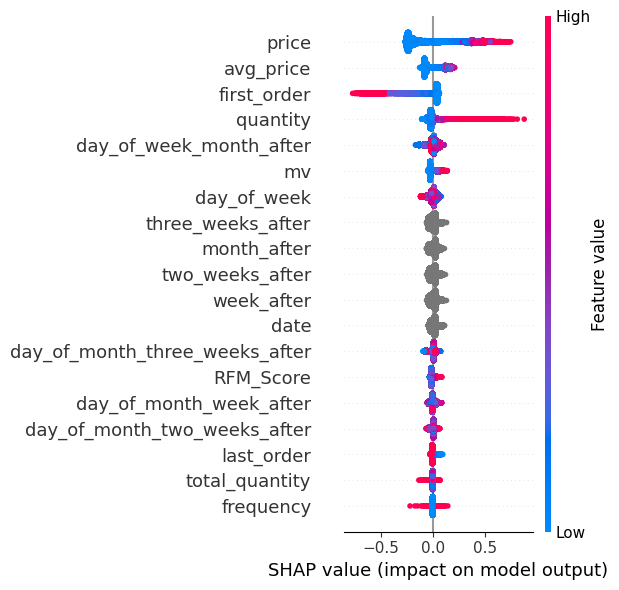

                                Влияение на целевой признак
price                                             29.043476
first_order                                        9.902122
quantity                                           6.741333
avg_price                                          6.141111
day_of_week_month_after                            5.636753
day_of_week                                        4.464133
month_after                                        4.130461
three_weeks_after                                  4.028234
day_of_month_three_weeks_after                     3.974245
week_after                                         3.850623
two_weeks_after                                    3.814941
day_of_month_week_after                            3.767942
date                                               3.542979
day_of_month_two_weeks_after                       3.528011
mv                                                 3.040585
RFM_Score                               

In [30]:
recall_importance = feature_importance(recall_cat, total_X_train)

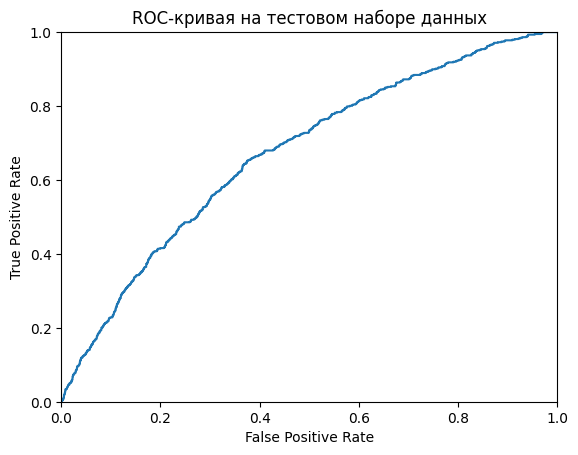

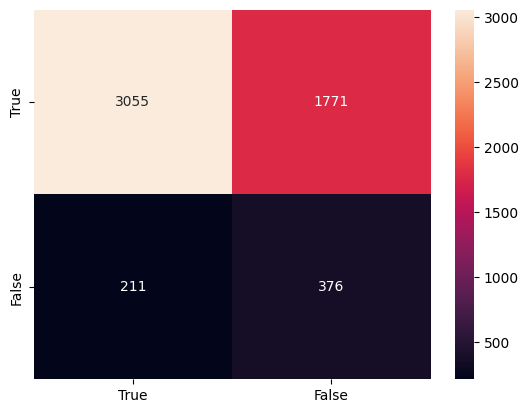

Правильно определённые клиенты - 3431 неправильно определённые клиенты - 1982
ROC-AUC на тестовой выборке 0.6716147839181718
F1 на тестовой выборке 0.2750548646671544
Recall на тестовой выборке 0.6405451448040886
Precision на тестовой выборке 0.1751280857009781


In [31]:
results_recall_total = results(recall_cat, total_X_test, total_y_test)

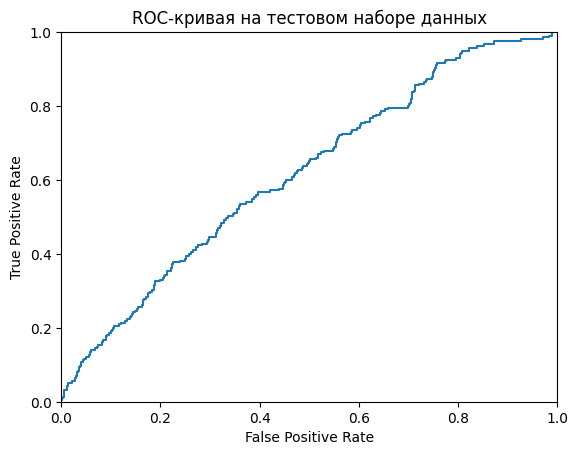

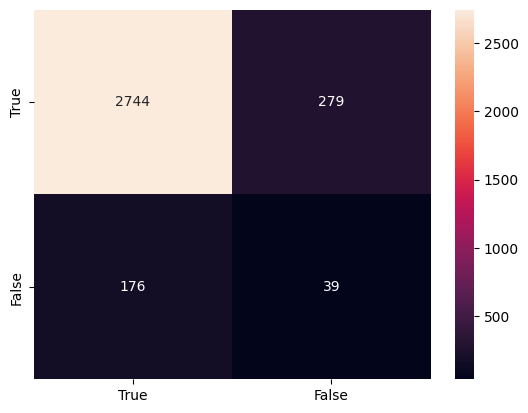

Правильно определённые клиенты - 2783 неправильно определённые клиенты - 455
ROC-AUC на тестовой выборке 0.6164336982360046
F1 на тестовой выборке 0.14634146341463417
Recall на тестовой выборке 0.1813953488372093
Precision на тестовой выборке 0.12264150943396226


In [32]:
results_recall_apparel = results(recall_cat, apparel_X_test, apparel_y_test)

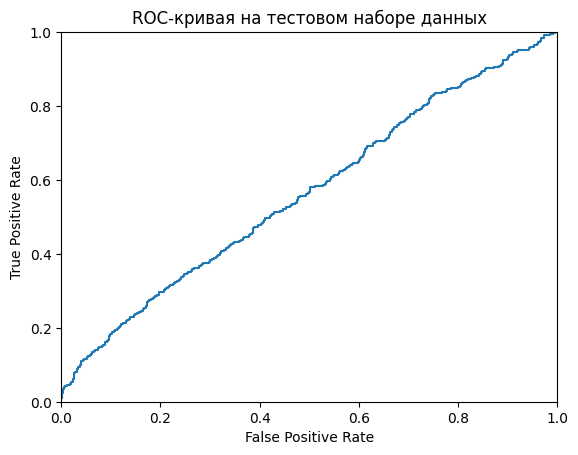

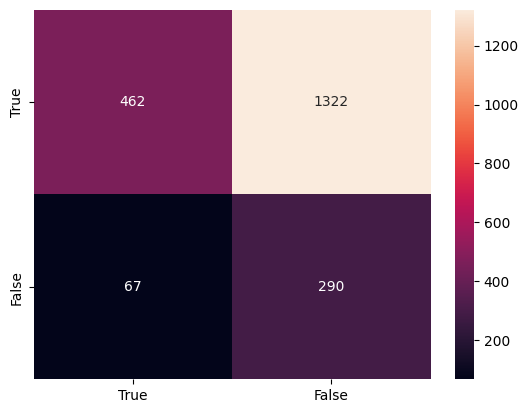

Правильно определённые клиенты - 752 неправильно определённые клиенты - 1389
ROC-AUC на тестовой выборке 0.5638620919219706
F1 на тестовой выборке 0.2945657694261047
Recall на тестовой выборке 0.8123249299719888
Precision на тестовой выборке 0.17990074441687345


In [33]:
results_recall_marketplace = results(recall_cat, marketplace_X_test, marketplace_y_test)

### ROC-AUC <a class="anchor"  id="2.2"></a>

In [34]:
auc_cat = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', iterations=4001,
                             cat_features=CAT_FEATURES, auto_class_weights='Balanced',
                             random_state=RANDOM_STATE, verbose=1000, metric_period=1000)

In [35]:
auc_cat_grid = auc_cat.grid_search(parameters, total_X_train, total_y_train, cv=4,
                                   partition_random_seed=RANDOM_STATE)
print('Лучшие параметры -', auc_cat.get_params(), ', лучший результат -',
      auc_cat_grid['cv_results']['test-AUC-mean'][-1])

0:	learn: 0.6012160	test: 0.6095479	best: 0.6095479 (0)	total: 58.5ms	remaining: 3m 53s
1000:	learn: 0.6451398	test: 0.6486194	best: 0.6486194 (1000)	total: 39.5s	remaining: 1m 58s
2000:	learn: 0.6555095	test: 0.6528849	best: 0.6528849 (2000)	total: 1m 18s	remaining: 1m 18s
3000:	learn: 0.6611687	test: 0.6543155	best: 0.6543155 (3000)	total: 1m 55s	remaining: 38.7s
4000:	learn: 0.6655295	test: 0.6550989	best: 0.6550989 (4000)	total: 2m 34s	remaining: 0us

bestTest = 0.6550988935
bestIteration = 4000

0:	loss: 0.6550989	best: 0.6550989 (0)	total: 2m 34s	remaining: 20m 35s
0:	learn: 0.6012160	test: 0.6095479	best: 0.6095479 (0)	total: 48.1ms	remaining: 3m 12s
1000:	learn: 0.6460409	test: 0.6498055	best: 0.6498055 (1000)	total: 39.9s	remaining: 1m 59s
2000:	learn: 0.6564740	test: 0.6533021	best: 0.6533021 (2000)	total: 1m 18s	remaining: 1m 18s
3000:	learn: 0.6621839	test: 0.6542711	best: 0.6542711 (3000)	total: 1m 55s	remaining: 38.5s
4000:	learn: 0.6676398	test: 0.6553570	best: 0.6553570

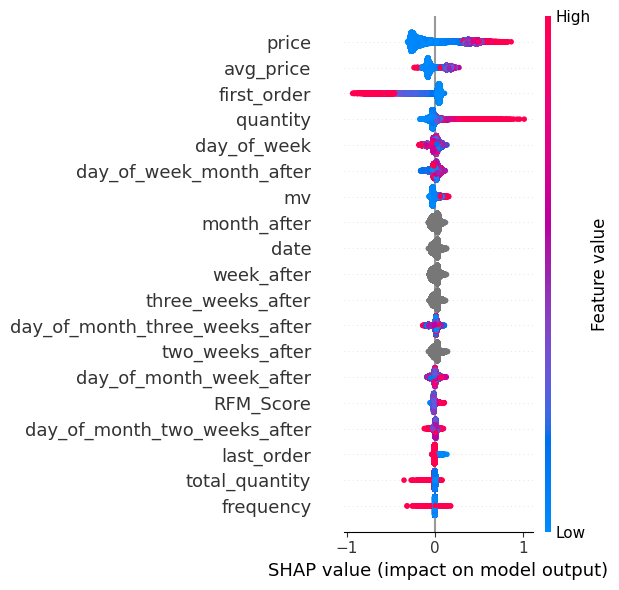

                                Влияение на целевой признак
price                                             21.758311
first_order                                        8.153264
quantity                                           6.957548
avg_price                                          6.563465
day_of_week                                        5.942443
day_of_week_month_after                            5.740303
day_of_month_three_weeks_after                     5.668913
day_of_month_week_after                            5.626426
day_of_month_two_weeks_after                       4.486724
month_after                                        3.917051
two_weeks_after                                    3.885059
week_after                                         3.843595
date                                               3.753838
three_weeks_after                                  3.680547
mv                                                 3.675422
RFM_Score                               

In [36]:
auc_importance = feature_importance(auc_cat, total_X_train)

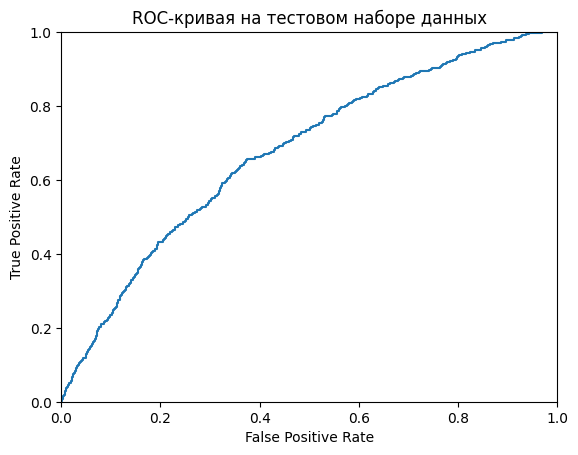

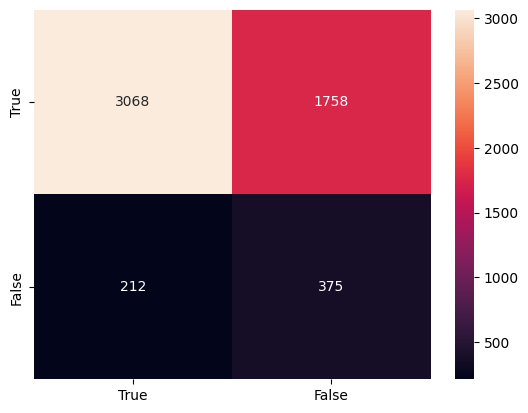

Правильно определённые клиенты - 3443 неправильно определённые клиенты - 1970
ROC-AUC на тестовой выборке 0.6755860327823946
F1 на тестовой выборке 0.275735294117647
Recall на тестовой выборке 0.6388415672913118
Precision на тестовой выборке 0.17580872011251758


In [37]:
results_auc_total = results(auc_cat, total_X_test, total_y_test)

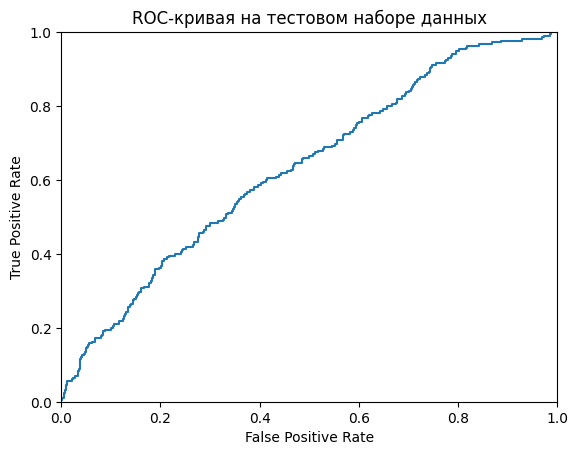

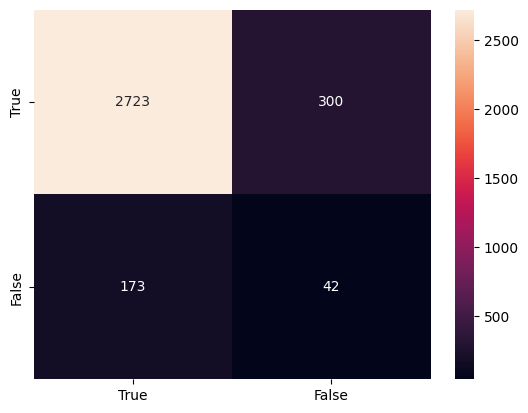

Правильно определённые клиенты - 2765 неправильно определённые клиенты - 473
ROC-AUC на тестовой выборке 0.6316411388655963
F1 на тестовой выборке 0.15080789946140033
Recall на тестовой выборке 0.19534883720930232
Precision на тестовой выборке 0.12280701754385964


In [38]:
results_auc_apparel = results(auc_cat, apparel_X_test, apparel_y_test)

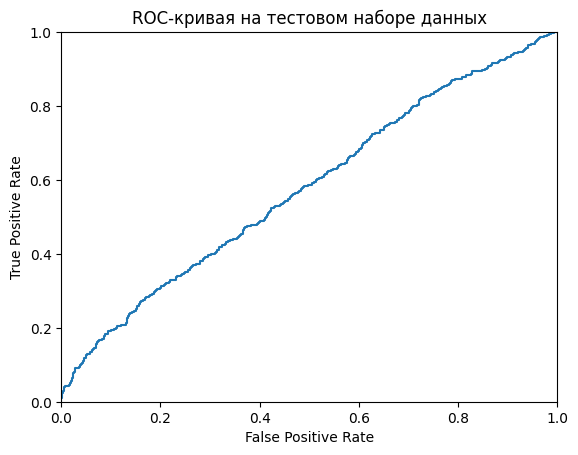

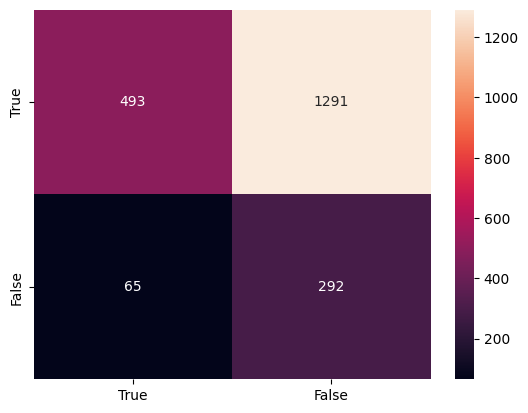

Правильно определённые клиенты - 785 неправильно определённые клиенты - 1356
ROC-AUC на тестовой выборке 0.5770936177161448
F1 на тестовой выборке 0.30103092783505153
Recall на тестовой выборке 0.8179271708683473
Precision на тестовой выборке 0.18445988629185092


In [39]:
results_auc_marketplace = results(auc_cat, marketplace_X_test, marketplace_y_test)

### Результаты обучения <a class="anchor"  id="2.3"></a>

In [40]:
pd.DataFrame([results_recall_total + results_auc_total,
              results_recall_apparel + results_auc_apparel,
              results_recall_marketplace + results_auc_marketplace],
             index=['test все данные', 'test apparel', 'test marketplace'],
             columns=['Recall модель, ROC-AUC', 'Recall модель, Recall',
                      'Recall модель, Precision', 'ROC-AUC модель, ROC-AUC',
                      'ROC-AUC модель, Recall', 'ROC-AUC модель, Precision'])

,"Recall модель, ROC-AUC","Recall модель, Recall","Recall модель, Precision","ROC-AUC модель, ROC-AUC","ROC-AUC модель, Recall","ROC-AUC модель, Precision"
test все данные,0.671615,0.640545,0.175128,0.675586,0.638842,0.175809
test apparel,0.616434,0.181395,0.122642,0.631641,0.195349,0.122807
test marketplace,0.563862,0.812325,0.179901,0.577094,0.817927,0.184460


In [43]:
recall_importance.head(10)

,Влияение на целевой признак
price,29.043476
first_order,9.902122
quantity,6.741333
avg_price,6.141111
day_of_week_month_after,5.636753
day_of_week,4.464133
month_after,4.130461
three_weeks_after,4.028234
day_of_month_three_weeks_after,3.974245
week_after,3.850623


In [44]:
auc_importance.head(10)

,Влияение на целевой признак
price,21.758311
first_order,8.153264
quantity,6.957548
avg_price,6.563465
day_of_week,5.942443
day_of_week_month_after,5.740303
day_of_month_three_weeks_after,5.668913
day_of_month_week_after,5.626426
day_of_month_two_weeks_after,4.486724
month_after,3.917051


Можно сказать, что обе модели получили примерно одинаковый результат. Recall модель определила немного больше клиентов, которые купят в течение 30 дней, но по всем остальным показателям модель, стремящаяся к чёткому разделению классов показала себя лучше. На основе таблицы выше можно сделать предположение, что среди всего набора данных модель хорошо предсказывала именно клиентов с маркетплейса. Возможно имеет смысл развивать усилия именно в направлении определения постоянных клиентов из этого источника.

## Общий вывод <a class="anchor"  id="3"></a>

Мы провели анализ данных и создали признаки, а затем обучили модели, способные опредить по данным о покупке и предыдущему поведению совершащих в следующие 30 дней ещё одну покупку клиентов. Модель обучалась на всём наборе данных, без разделения на магазины, и показала разную эффективность на разных тестовых данных. Было бы здорово увеличить количество данных, на основе которых можно обучить модель, особенно данных с маркетплейса, это направление кажется самым многообещающим. К магазину одежды вероятно лучше подходить с точки зрения RFM анализа.